In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import glob
from natsort import natsorted
from scipy import stats

In [2]:
hex6 = ['#648FFF', '#785EF0', '#DC267F', '#FE6100', '#FFB000']
colors6=[mcolors.to_rgb(i) for i in hex6]

In [14]:
# Note: Cosine similarity is defined for the embedding layers whereas ID and NO are defined for the model layers.

all_models = ['Llama-3-8B', 'Mistral-7B', 'Pythia-6.9B']
NCOL = 3 if len(all_models) <= 3 else 2
model_titles = {'Llama-3-8B' : 'Llama-3-8B' , 'Mistral-7B':'Mistral-7B', 'Pythia-6.9B':'Pythia-6.9B', 'Pythia-6.9B-Deduped':'Pythia-6.9B (D)'}
num_prompts, num_layers = 2244, 32
input_dir = '../Pile-Structured'
losses = {}
"""
This was the older version
for model_name in all_models:
    ifiles = f'{input_dir}/{model_name}/losses/*.npy'
    filelst= natsorted(glob.glob(ifiles)) 
    losses[model_name] = np.concatenate([np.load(file) for file in filelst], axis = 0)
    np.save(f'{input_dir}/{model_name}/summaries/losses.npy', losses[model_name])
"""
for model_name in all_models:
    losses[model_name] = np.load(f'{input_dir}/{model_name}/summaries/losses.npy')
    
csn_sims = {}
for model_name in all_models:
    csn_sims[model_name] = np.load(f'{input_dir}/{model_name}/summaries/csn_sim.npy').transpose([0, 2, 1])
    
ids = {}
for model_name in all_models:
    ids[model_name] = np.load(f'{input_dir}/{model_name}/summaries/gride.npy')[:,:, 0, :]
    
mnos = {}
for model_name in all_models:
    mnos[model_name] = np.load(f'{input_dir}/{model_name}/summaries/mnos.npy')
    

cmp = {'Llama-3-8B': colors6[3], 'Mistral-7B': colors6[2], 'Pythia-6.9B': colors6[0]}

TEST_INDX_SHUFFLE = 14 # The test prompt we use throughout the paper to display results for a single prompt.
filtered_indices = np.load('../../filtered_indices.npy')
subset_indices = np.load('../../subset_indices.npy')
TEST_INDX = np.where(filtered_indices == subset_indices[TEST_INDX_SHUFFLE])[0][0] # The test prompt we use throughout the paper to display results for a single prompt.
TEST_INDX

686

## Comparing token geometry of prompts in different models (Section 4.3)

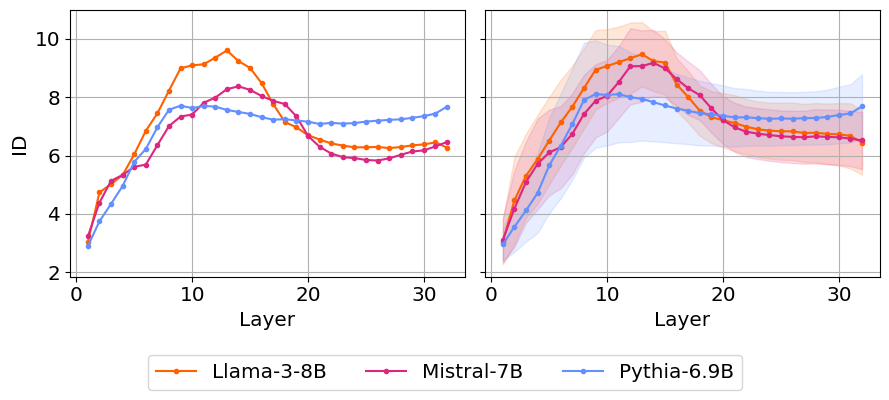

In [15]:
xrange = np.arange(1, num_layers + 1)
fig, axes = plt.subplots(1, 2, figsize = (9, 3.5), sharey = True)
rs_idx = 0
for idx in range(2):
    for jdx, model_name in enumerate(all_models):
        ax = axes[idx]
        if idx == 0:
            id_model = ids[model_name][TEST_INDX,:,rs_idx]
            ax.plot(np.arange(1, num_layers+1), id_model, label = model_titles[model_name], marker = '.', c = cmp[model_name])
            ax.set_ylabel("ID", fontsize = "x-large")
        if idx == 1:
            op = ids[model_name][:, :, rs_idx]
            # Calculate mean and standard deviation
            mean_op = op.mean(axis=0)
            std_op = op.std(axis=0)

            # Plot the mean curve
            ax.plot(xrange, mean_op, label = model_name, color=cmp[model_name], marker = '.')

            # Fill between the mean +/- std (shaded area)
            ax.fill_between(xrange, mean_op - std_op, mean_op + std_op, color=cmp[model_name], alpha=0.15)


        ax.set_xlabel("Layer", fontsize = "x-large")
        ax.tick_params(which='both', labelsize="x-large")
        ax.grid(True)

plt.tight_layout()
handles_psim, labels_psim = axes[0].get_legend_handles_labels()
fig.legend(handles_psim, labels_psim, loc='upper center', bbox_to_anchor=(0.5, -0.0), ncol = NCOL,  fontsize = "x-large")
plt.savefig(f'figs/models/id_{TEST_INDX}.png', bbox_inches='tight')
plt.show()

### NO

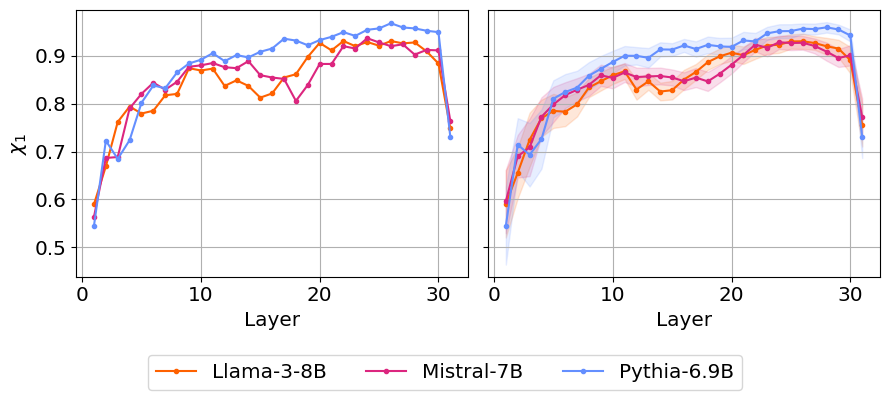

In [5]:

fig, axes = plt.subplots(1, 2, figsize = (9, 3.5), sharey = "row")
knn = 1
xrange = np.arange(1, num_layers)
for idx in range(2):
    for jdx, model_name in enumerate(all_models):
        
        ax = axes[idx]
        if idx == 0:
            mno_model = mnos[model_name][TEST_INDX,:,knn]
            ax.plot(xrange, mno_model, label = model_titles[model_name], marker = '.', c = cmp[model_name])
            
            ax.set_ylabel(f"$\chi_{knn}$", fontsize = "x-large")
        if idx == 1:
            op = mnos[model_name][:,:,knn]
    
            # Calculate mean and standard deviation
            mean_op = op.mean(axis=0)
            std_op = op.std(axis=0)

            # Plot the mean curve
            ax.plot(xrange, mean_op, label = model_name, color=cmp[model_name], marker = '.')

            # Fill between the mean +/- std (shaded area)
            ax.fill_between(xrange, mean_op - std_op, mean_op + std_op, color=cmp[model_name], alpha=0.15)


        ax.set_xlabel("Layer", fontsize = "x-large")
        ax.tick_params(which='both', labelsize="x-large")
        ax.grid(True)

handles_psim, labels_psim = axes[0].get_legend_handles_labels()
fig.legend(handles_psim, labels_psim, loc='upper center', bbox_to_anchor=(0.5, -0.0), ncol = NCOL,  fontsize = "x-large")

plt.tight_layout()
plt.savefig(f'figs/models/no_knn_{knn}_{TEST_INDX}.png', bbox_inches='tight')
plt.show()

### Correlation with loss

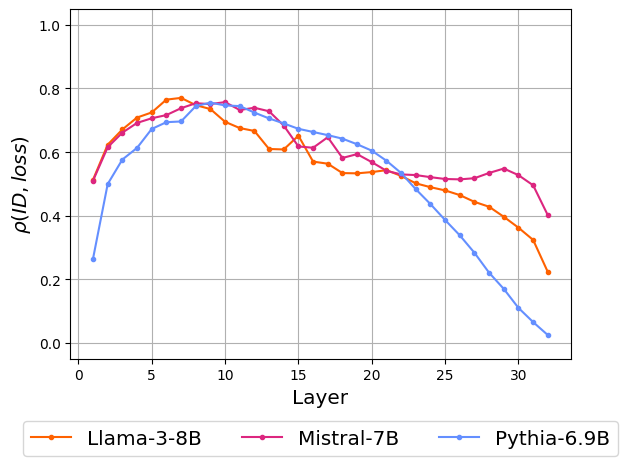

In [16]:
for jdx, model_name in enumerate(all_models):
    rs_idx = 0
    id_model, loss_model = ids[model_name], losses[model_name]
    pearson = [stats.pearsonr(id_model[:, lnum, 0], loss_model).statistic for lnum in range(num_layers)]  
    plt.plot(np.arange(1, num_layers+1), pearson, label = model_titles[model_name], marker = '.', c = cmp[model_name])
    # plt.title(f'Intrinsic Dimension',  fontsize = "x-large")
    plt.ylabel("$\\rho(ID, loss)$", fontsize = "x-large")
    plt.xlabel("Layer", fontsize = "x-large")
plt.ylim(-0.05,1.05)
plt.grid(True)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=NCOL, fontsize="x-large")
plt.tight_layout()
plt.savefig(f'figs/models/loss_id_correlation.png', bbox_inches='tight')


In [7]:
# p-value check
cutoff = 0.01
for jdx, model_name in enumerate(all_models):
    rs_idx = 0
    id_model, loss_model = ids[model_name], losses[model_name]
    pvals = [stats.pearsonr(id_model[:, lnum, 0], loss_model).pvalue for lnum in range(num_layers)]
    for lnum in range(num_layers): 
        pval = pvals[lnum]
        if pval > cutoff:
            print(f"Correlation between loss and ID has p-value = {pval:.2f} for model = {model_name} and layer = {lnum + 1}")
print(f"The p-value is less than {cutoff} for other model and layer combinations.")

Correlation between loss and ID has p-value = 0.26 for model = Pythia-6.9B and layer = 32
The p-value is less than 0.01 for other model and layer combinations.


## Appendix

### Range scaling analysis

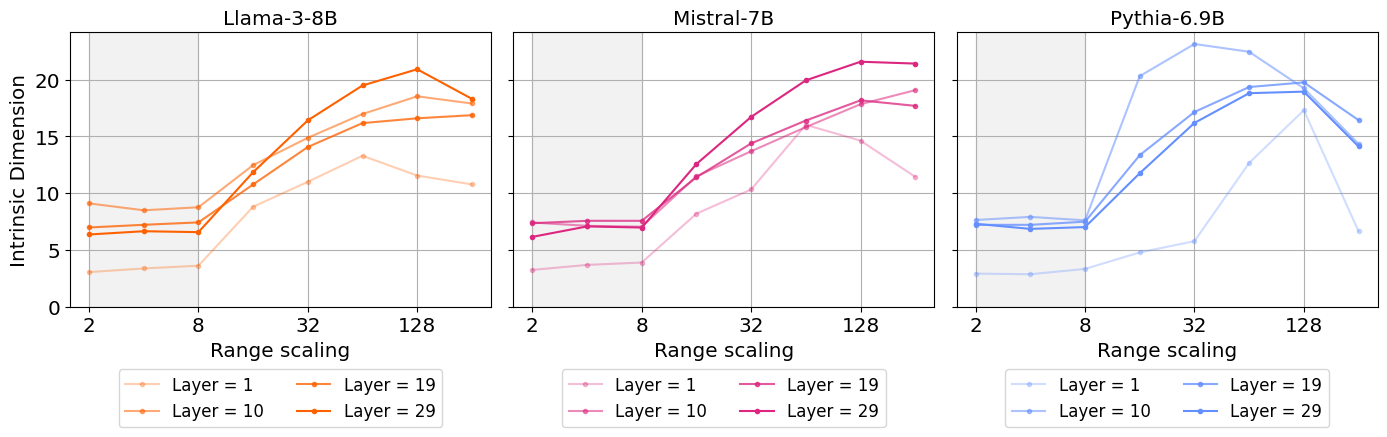

In [8]:
from matplotlib import colormaps

vmap = colormaps['viridis']

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(14, 5), sharey="row")

for jdx, model_name in enumerate(all_models):
    ax = axes[jdx]
    id_model = ids[model_name][TEST_INDX,:,:]
    for erdx, layers in enumerate(np.linspace(0, num_layers - 4, 4, dtype = np.int32)):
        alpha = np.linspace(0.3, 1, 4)[erdx]
        x = np.array([2**i for i in range(1, 9)])
        ax.plot(x , id_model[layers], label = f"Layer = {layers + 1}", marker = '.', c = cmp[model_name], alpha = alpha)
        ax.legend(loc = 'upper left', fontsize = "large")
        ax.set_xscale('log', base=2)
        ax.set_title(model_name, fontsize = "x-large")
        ax.set_xticks(x[::2], x[::2])

    if jdx == 0: ax.set_ylabel("Intrinsic Dimension", fontsize = "x-large")
    ax.set_xlabel("Range scaling", fontsize = "x-large")
    ax.tick_params(which='both', labelsize="x-large")
    ax.grid(True)
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.47), ncol=2, fontsize="large")
    
    if jdx == 2: ax.set_ylim(0)
    
for jdx, ax in enumerate(axes) : ax.fill_betweenx(ax.get_ylim(), 2, 8, color='gray', alpha=0.1)
    


plt.tight_layout()
plt.savefig(f'figs/models/appendix/scale_analysis_{TEST_INDX}.png', bbox_inches='tight')
plt.show()

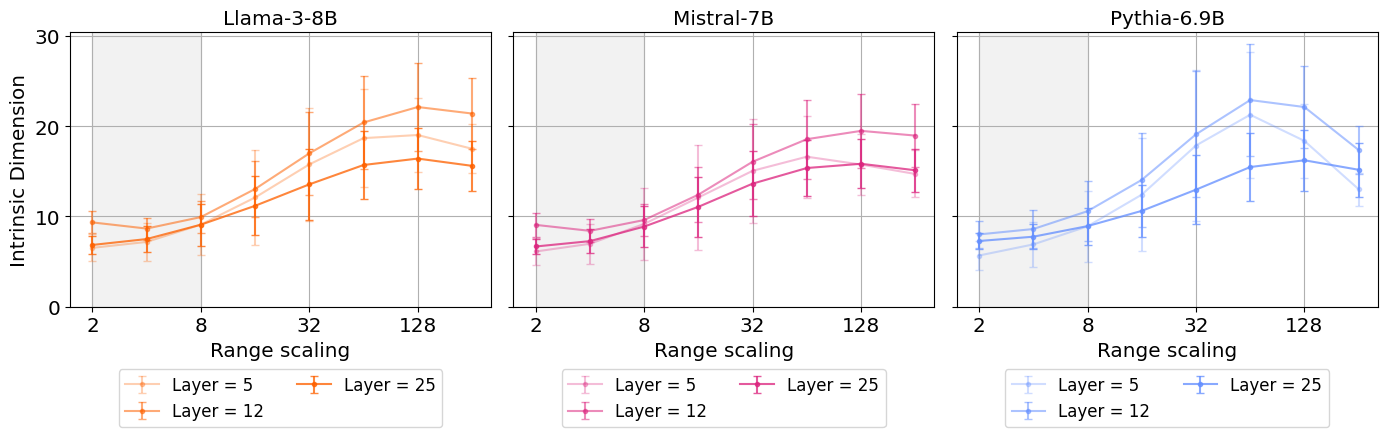

In [9]:
from matplotlib import colormaps

vmap = colormaps['viridis']

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(14, 5), sharey="row")

for jdx, model_name in enumerate(all_models):
    ax = axes[jdx]    
    for erdx, layers in enumerate([4, 11, 24]):
        op = ids[model_name][:,layers,:]
        
        xrange = np.array([2**i for i in range(1, 9)])
        
        alpha = np.linspace(0.3, 1, 4)[erdx]
        # Calculate mean and standard deviation
        mean_op = op.mean(axis=0)
        std_op = op.std(axis=0)
        
        ax.errorbar(x = xrange, y = mean_op, capsize = 3, yerr = std_op, label = f"Layer = {layers + 1}", marker = '.', c = cmp[model_name], alpha = alpha)
        
        ax.legend(loc = 'upper left', fontsize = "large")
        ax.set_xscale('log', base=2)
        ax.set_title(model_name, fontsize = "x-large")
        ax.set_xticks(x[::2], x[::2])
        ax.set_xlim(1.5)

    if jdx == 0: ax.set_ylabel("Intrinsic Dimension", fontsize = "x-large")
    ax.set_xlabel("Range scaling", fontsize = "x-large")
    ax.tick_params(which='both', labelsize="x-large")
    ax.grid(True)
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.47), ncol=2, fontsize="large")
    
    if jdx == 2: ax.set_ylim(0)
    
for jdx, ax in enumerate(axes) : ax.fill_betweenx(ax.get_ylim(), 2, 8, color='gray', alpha=0.1)
    


plt.tight_layout()
plt.savefig(f'figs/models/appendix/scale_analysis_mean.png', bbox_inches='tight')
plt.show()

### Average ID profiles for different models

#### Normalized by median

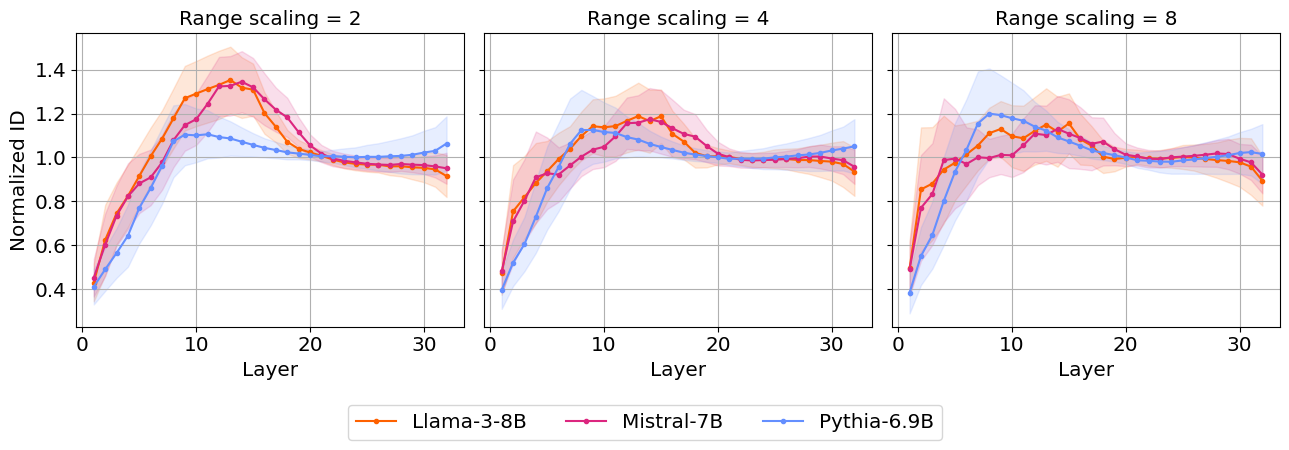

In [10]:
xrange = np.arange(1, num_layers + 1)
fig, axes = plt.subplots(1, 3, figsize = (13, 4), sharey = "row")
for qdx, rs_idx in enumerate(range(0,3)):
    ax = axes[qdx]
    for idx, model_name in enumerate(all_models):
            op = ids[model_name][:, :, rs_idx]/np.median(ids[model_name][:, :, rs_idx], axis = -1, keepdims = True)
    
            # Calculate mean and standard deviation
            mean_op = op.mean(axis=0)
            std_op = op.std(axis=0)

            # Plot the mean curve
            ax.plot(xrange, mean_op, label = model_name, color=cmp[model_name], marker = '.')

            # Fill between the mean +/- std (shaded area)
            ax.fill_between(xrange, mean_op - std_op, mean_op + std_op, color=cmp[model_name], alpha=0.15)
    if qdx == 0: ax.set_ylabel("Normalized ID", fontsize = "x-large")
    ax.set_xlabel("Layer", fontsize = "x-large")
    ax.set_title(f"Range scaling = {2*2**qdx}", fontsize = "x-large")
    ax.tick_params(which='both', labelsize="x-large")
    ax.grid(True)
handles_psim, labels_psim = axes[0].get_legend_handles_labels()
fig.legend(handles_psim, labels_psim, loc='upper center', bbox_to_anchor=(0.5, -0.0), ncol = NCOL,  fontsize = "x-large")

plt.tight_layout()
plt.savefig('figs/models/appendix/gride_median_avg.png', bbox_inches = 'tight')
plt.show()

#### Without normalzing

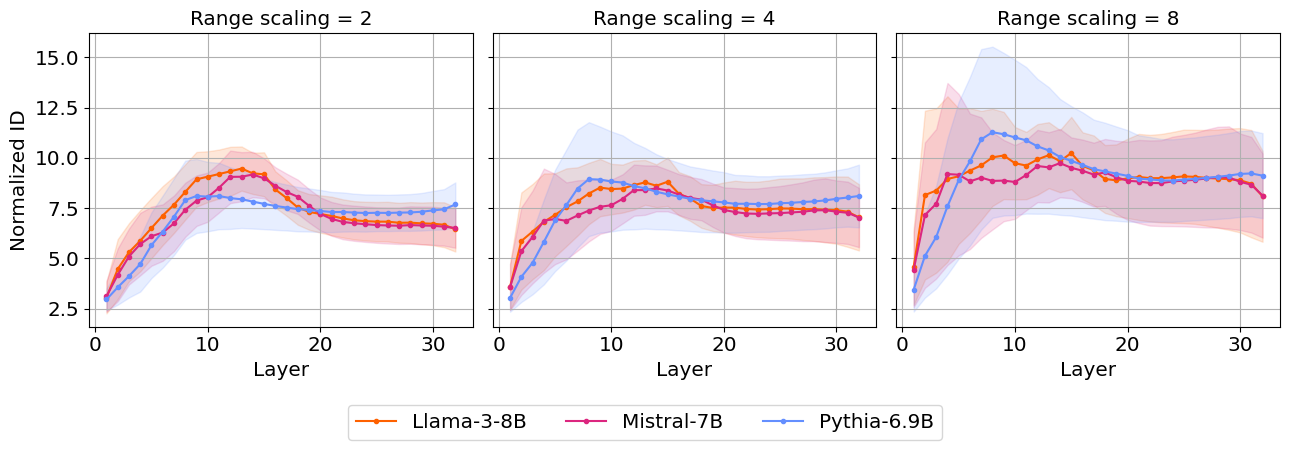

In [11]:
xrange = np.arange(1, num_layers + 1)
fig, axes = plt.subplots(1, 3, figsize = (13, 4), sharey = "row")
for qdx, rs_idx in enumerate(range(0,3)):
    ax = axes[qdx]
    for idx, model_name in enumerate(all_models):
            op = ids[model_name][:, :, rs_idx]
    
            # Calculate mean and standard deviation
            mean_op = op.mean(axis=0)
            std_op = op.std(axis=0)

            # Plot the mean curve
            ax.plot(xrange, mean_op, label = model_name, color=cmp[model_name], marker = '.')

            # Fill between the mean +/- std (shaded area)
            ax.fill_between(xrange, mean_op - std_op, mean_op + std_op, color=cmp[model_name], alpha=0.15)
    if qdx == 0: ax.set_ylabel("Normalized ID", fontsize = "x-large")
    ax.set_xlabel("Layer", fontsize = "x-large")
    ax.set_title(f"Range scaling = {2*2**qdx}", fontsize = "x-large")
    ax.tick_params(which='both', labelsize="x-large")
    ax.grid(True)
handles_psim, labels_psim = axes[0].get_legend_handles_labels()
fig.legend(handles_psim, labels_psim, loc='upper center', bbox_to_anchor=(0.5, -0.0), ncol = NCOL,  fontsize = "x-large")
plt.tight_layout()
plt.savefig('figs/models/appendix/gride_mean_avg.png', bbox_inches = 'tight')
plt.show()

### Correlation to loss for different range scalings

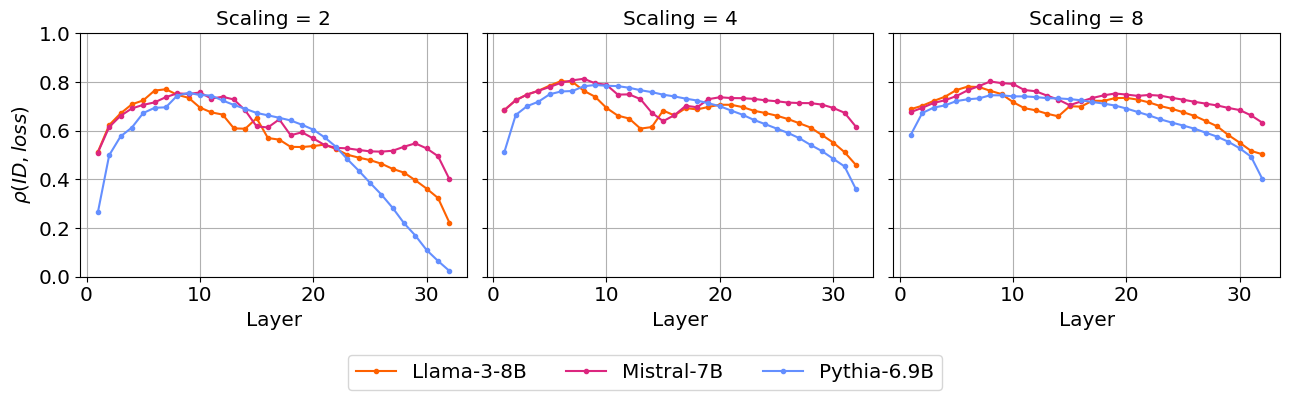

In [12]:
fig, axes = plt.subplots(1, 3, figsize = (13, 3.5), sharey = "row")
for rs_idx in range(3):
    ax = axes[rs_idx]
    for idx, model_name in enumerate(all_models):
        id_model, loss_model = ids[model_name], losses[model_name]
        pearson = [np.corrcoef(id_model[:, lnum, rs_idx], loss_model)[0,1] for lnum in range(num_layers)]  
        ax.plot(np.arange(1, num_layers+1), pearson, label = model_titles[model_name], marker = '.', c = cmp[model_name])
        ax.grid(True)
        ax.set_title(f'Scaling = {2**(rs_idx + 1)}',  fontsize = "x-large")
        if rs_idx == 0: ax.set_ylabel("$\\rho(ID, loss)$", fontsize = "x-large")
        ax.set_xlabel("Layer", fontsize = "x-large")
        ax.set_ylim(0,1)
        ax.tick_params(which='both', labelsize="x-large")
        
handles_psim, labels_psim = axes[0].get_legend_handles_labels()
fig.legend(handles_psim, labels_psim, loc='upper center', bbox_to_anchor=(0.5, -0.0), ncol = NCOL,  fontsize = "x-large")

plt.tight_layout()
plt.savefig('figs/models/appendix/gride_loss_corr.png', bbox_inches = 'tight')
plt.show()